### Problem Statement

* Solve the 1D diffusion equation for the evolution of some concentration $c(x,t)$ with diffusion coefficient $D$
  $$
  \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}
  $$

  in the domain $x \in [-1,1]$, $t \in [1,2]$ given some experimental data points $(x_i,t_i,c(x_i,t_i))$ from the boundary condition
  $$
  c(x,1)=\frac{1}{\sqrt{4\pi D}}\exp\left(\frac{-x^2}{4D}\right).
  $$

* For reference, the analytical solution of the problem is
  $$
  c(x,t) = \frac{1}{\sqrt{4 \pi D t}}\exp\left(\frac{-x^2}{4Dt}\right).
  $$
  In the following $D=1$ for simplicity.

### Training Setup

In [11]:
import torch
import torch.nn as nn
import numpy as np

The function $f$ to be fulfilled by the PINN is
$$
f(x,t)= \frac{\partial c(x,t)}{\partial t} - \frac{\partial^2 c(x,t)}{\partial x^2} = 0.
$$

The later loss will then be 
$$
L_{PDE} = \frac{1}{N} \sum_{i=1}^N f(x_i, t_i)^2.
$$

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        # we have two input variables x,t and one predicted output variable c(x,t)
        self.layer1 = nn.Linear(2,5)
        self.layer2 = nn.Linear(5,5)
        self.layer3 = nn.Linear(5,5)
        self.layer4 = nn.Linear(5,5)
        self.layer5 = nn.Linear(5,1)
    
    def forward(self, x, t):
        input = torch.cat((x, t), dim=1)
        l1_out = torch.sigmoid(self.layer1(input))
        l2_out = torch.sigmoid(self.layer2(l1_out))
        l3_out = torch.sigmoid(self.layer3(l2_out))
        l4_out = torch.sigmoid(self.layer4(l3_out))
        l5_out = self.layer5(l4_out)
        return l5_out
    
    # this is the function f(x,t) on which the physics loss will be computed
    def pde_f(self, x, t): 
        c = self.forward(x,t)
        # use grad_outputs to set which elements to compute gradient on 
        # use create_graph to also create computational graph on gradient operation
        c_x = torch.autograd.grad(c, x, grad_outputs=torch.ones_like(c), create_graph=True)[0]
        c_xx = torch.autograd.grad(c_x, x, grad_outputs=torch.ones_like(c_x), create_graph=True)[0]
        c_t = torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c), create_graph=True)[0]
        f = c_t-c_xx
        return f
    
net = PINN().to(device)
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [13]:
# Create "experimental" points that fulfill initial condition 
x_bc = np.random.uniform(low=-1.0, high=1.0, size=(100,1))
t_bc = np.ones((100,1))
c_bc = (4*np.pi)**(-1/2)*np.exp(-x_bc**2/4)

x_bc_tensor = torch.from_numpy(x_bc).float().to(device)
t_bc_tensor = torch.from_numpy(t_bc).float().to(device)
c_bc_tensor = torch.from_numpy(c_bc).float().to(device)

In [14]:
epoches = 10000
for epoch in range(epoches):
    optimizer.zero_grad()

    # Boundary condition loss
    nnet_c_bc= net.forward(x_bc_tensor, t_bc_tensor)
    data_loss = mse_loss(nnet_c_bc, c_bc_tensor)

    # Physics loss (due to PDE) 
    # Each epoch random points are generated and evaluated for how well the PINN is fulfilling the PDE at their location
    x_random = torch.from_numpy(np.random.uniform(low=-1.0, high=1.0, size=(100,1))).float().requires_grad_(True)
    t_random = torch.from_numpy(np.random.uniform(low=1, high=2, size=(100,1))).float().requires_grad_(True)
    net_f = net.pde_f(x_random, t_random)
    pde_loss = torch.mean(net_f**2)

    # Backpropagation
    loss = data_loss + pde_loss
    loss.backward()
    optimizer.step()

    if epoch%1000==0:
        with torch.autograd.no_grad():
            print(epoch, "Loss:", loss.data)


0 Loss: tensor(0.2368)
1000 Loss: tensor(0.0004)
2000 Loss: tensor(0.0003)
3000 Loss: tensor(0.0003)
4000 Loss: tensor(0.0003)
5000 Loss: tensor(0.0003)
6000 Loss: tensor(0.0003)
7000 Loss: tensor(0.0003)
8000 Loss: tensor(0.0002)
9000 Loss: tensor(4.0292e-05)


### Plotting (with comparison to analytical solution)

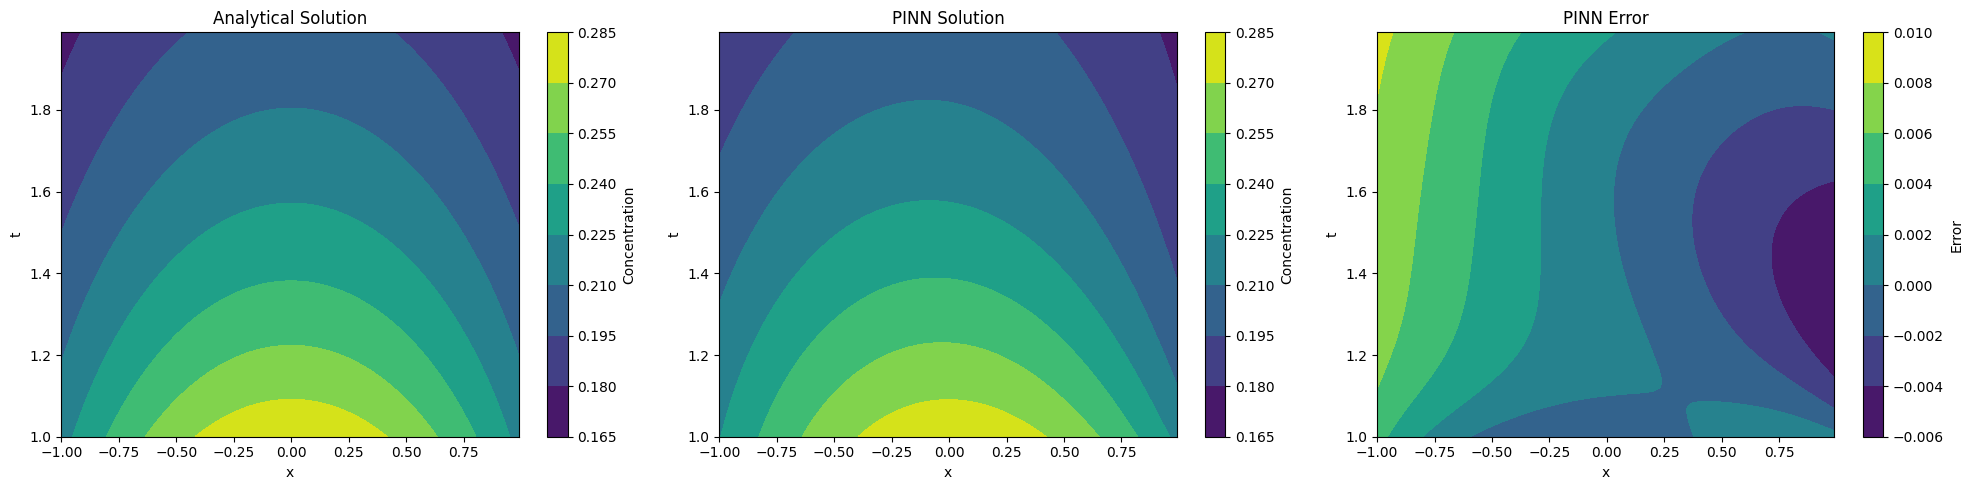

In [15]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20,5))

# Create 2D analytical solution subplot over a mesh 
x = np.arange(-1,1, 0.01)
t = np.arange(1,2, 0.01)
X,T = np.meshgrid(x,t)

def exact_f(x,t):
    D=1
    return (4*np.pi*D*t)**(-1/2)*np.exp(-x**2/(4*D*t))
C_analytical = exact_f(X,T)

contour1 = axs[0].contourf(X,T, C_analytical, cmap="viridis")
fig.colorbar(contour1, ax=axs[0], label="Concentration")
axs[0].set_title("Analytical Solution")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")


# Create PINN solution subplot over same mesh
# The inputs have to be reshaped first to be fed into the PINN
X_torch = torch.tensor(X).float().reshape(-1,1)
T_torch = torch.tensor(T).float().reshape(-1,1)

with torch.no_grad():
    # the PINN output is reshaped to the meshgrid structure
    C_pinn = net.forward(X_torch, T_torch).reshape(X.shape).numpy()

contour2 = axs[1].contourf(X,T, C_pinn, cmap="viridis")
fig.colorbar(contour2, ax=axs[1], label="Concentration")
axs[1].set_title("PINN Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")


# Error subplot between both solutions
C_error = C_pinn-C_analytical

contour3 = axs[2].contourf(X,T, C_error, cmap="viridis")
fig.colorbar(contour3, ax=axs[2], label="Error")
axs[2].set_title("PINN Error")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")


plt.tight_layout()
plt.show()

### Conclusion

* The deviation at the worst points amounts to ~4% (without having majorly optimized the NN). Deviations increase further from the initial condition as future predictions become less informed. Asymmetries are created by unevenly distributed intial points.
* With only 100 random initial "experimental" points (which form the boundary/initial condition) it is possible to compute the concentration time evolution quite accurately. 
* The PINN's strength in this example lies in the 1,000,000 artificially generated points at which the PDE validity is checked. Even with little training data, it is therefore possible to obtain good predictions. 